In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

In [53]:
df= pd.read_csv('../input/onion12/onion(lstm).csv',encoding='cp949')
df.head()

,date,uga,sun,ondo,price
0,2015-01-02,53.27,7.07,1.0,520
1,2015-01-05,50.98,6.49,6.9,520
2,2015-01-06,48.08,9.88,2.6,520
3,2015-01-07,46.60,8.22,0.0,520
4,2015-01-08,47.50,6.12,1.7,520


In [54]:
sun=df['sun']
ondo=df['ondo']
uga=df['uga']
price=df['price']
date=['date']

Text(0.5, 1.0, 'price')

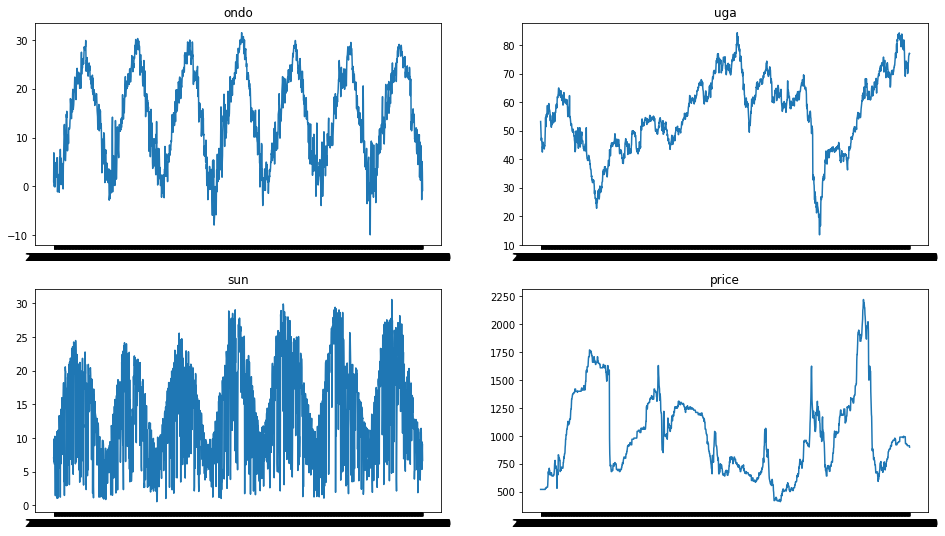

In [55]:
plt.figure(figsize=(16, 9))
plt.subplot(221)
plt.plot(df['date'], df['ondo'],label='ondo')
plt.title('ondo')

plt.subplot(222)
plt.plot(df['date'], df['uga'],label='uga')
plt.title('uga')

plt.subplot(223)
plt.plot(df['date'], df['sun'],label='sun')
plt.title('sun')

plt.subplot(224)
plt.plot(df['date'], df['price'],label='price')
plt.title('price')

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['uga', 'ondo', 'sun', 'price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled

array([[0.56049069, 0.26328502, 0.21685543, 0.0607064 ],
       [0.52820079, 0.4057971 , 0.19753498, 0.0607064 ],
       [0.48730964, 0.30193237, 0.31045969, 0.0607064 ],
       ...,
       [0.89382403, 0.36231884, 0.23650899, 0.27704194],
       [0.89847716, 0.30917874, 0.28580946, 0.27704194],
       [0.89678511, 0.21980676, 0.20386409, 0.26986755]])

In [57]:
df = pd.DataFrame(scaled, columns=scale_cols)
df

,uga,ondo,sun,price
0,0.560491,0.263285,0.216855,0.060706
1,0.528201,0.405797,0.197535,0.060706
2,0.487310,0.301932,0.310460,0.060706
3,0.466441,0.239130,0.255163,0.060706
4,0.479131,0.280193,0.185210,0.060706
...,...,...,...,...
1772,0.882685,0.173913,0.296802,0.277042
1773,0.887620,0.330918,0.159893,0.277042
1774,0.893824,0.362319,0.236509,0.277042
1775,0.898477,0.309179,0.285809,0.277042


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[['ondo', 'sun', 'uga']],df['price'],test_size=0.2, random_state=12, shuffle=False)

In [59]:
x_train.shape, y_train.shape

((1421, 3), (1421,))

In [60]:
x_test.shape, y_test.shape

((356, 3), (356,))

In [61]:
x_train

,ondo,sun,uga
0,0.263285,0.216855,0.560491
1,0.405797,0.197535,0.528201
2,0.301932,0.310460,0.487310
3,0.239130,0.255163,0.466441
4,0.280193,0.185210,0.479131
...,...,...,...
1416,0.932367,0.736176,0.421884
1417,0.903382,0.836442,0.436266
1418,0.896135,0.797135,0.426960
1419,0.891304,0.809793,0.428229


In [62]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [63]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [64]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [65]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Bidirectional,Dropout,BatchNormalization
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh',return_sequences = True),
    LSTM(32, activation='relu',return_sequences = True),
    LSTM(64, activation='relu',return_sequences = True),
    Bidirectional(LSTM(128, activation='relu',return_sequences = True)),
    Bidirectional(LSTM(256, activation='relu',return_sequences = False)),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [68]:
optimizer = Adam(0.0005)
model.compile(loss = Huber(), optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [69]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [70]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=200, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
44/44 [==============================] - 22s 308ms/step - loss: 0.0231 - root_mean_squared_error: 0.2149 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1656

Epoch 00001: val_loss improved from inf to 0.01371, saving model to tmp/ckeckpointer.ckpt
Epoch 2/200
44/44 [==============================] - 11s 250ms/step - loss: 0.0033 - root_mean_squared_error: 0.0817 - val_loss: 0.0066 - val_root_mean_squared_error: 0.1150

Epoch 00002: val_loss improved from 0.01371 to 0.00662, saving model to tmp/ckeckpointer.ckpt
Epoch 3/200
44/44 [==============================] - 12s 270ms/step - loss: 0.0029 - root_mean_squared_error: 0.0759 - val_loss: 0.0064 - val_root_mean_squared_error: 0.1131

Epoch 00003: val_loss improved from 0.00662 to 0.00640, saving model to tmp/ckeckpointer.ckpt
Epoch 4/200
44/44 [==============================] - 11s 254ms/step - loss: 0.0029 - root_mean_squared_error: 0.0762 - val_loss: 0.0055 - val_root_mean_squared_error: 0.1052

Epoch 00004: val_loss 

In [71]:
pred = model.predict(test_data)
pred.shape

(336, 1)

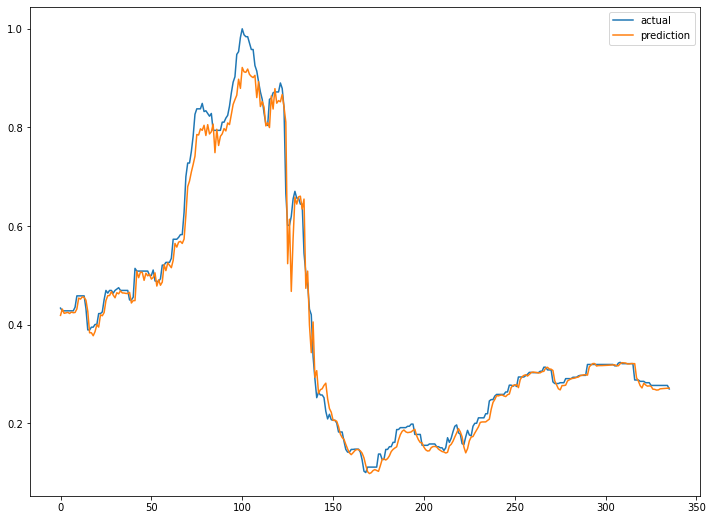

In [74]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [75]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

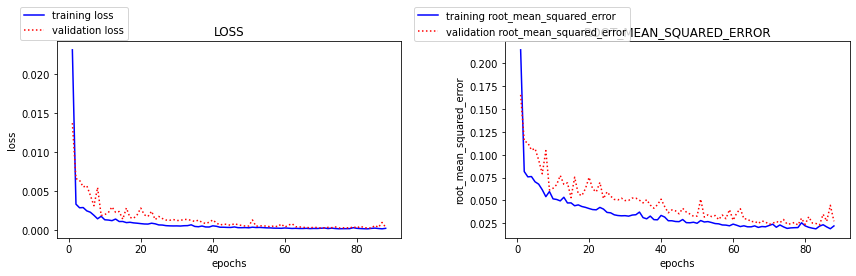

In [76]:
plot_history(history)

In [77]:
import tensorflow.keras as keras
x_test_t = x_test.values.reshape(x_test.shape[0], 3, 1)
y_test_t = y_test.values.reshape(y_test.shape[0], 1)

In [78]:
score=model.evaluate(x_test_t,y_test,batch_size=32)

12/12 [==============================] - 1s 6ms/step - loss: 0.0568 - root_mean_squared_error: 0.3372


In [79]:
model.save('onion(lstm)1.h5')

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

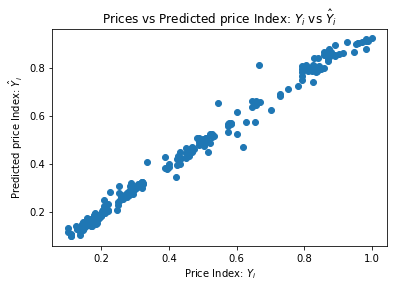

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt


y_pred = model.predict(train_data, batch_size=32)
plt.scatter(y_test[20:], pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")

In [81]:
pred1 = pd.DataFrame(pred)
 
pred1.to_csv('pred.csv', index=False)
y_test1=y_test[20:]
y_test1 = pd.DataFrame(y_test1)
 
y_test1.to_csv('y_test(mu).csv', index=False)